# Fashion-MNIST 데이터에 대하여 컨볼루션 신경망(CNN)을 사용하여 이미지 분류 작업 수행

***

## 목표

- 이미지 데이터의 형태와 클래스 레이블을 시각적으로 탐색하고 분석
- 간단한 CNN 모델 구축
- 손실 함수와 최적화 알고리즘을 선택
- 손실과 정확도를 모니터링
- 데이터셋을 사용하여 모델을 평가하고, 최종 정확도를 보고
- 잘못 분류된 이미지들을 분석
- 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지를 식별

***

### 라이브러리 import

In [1]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

import matplotlib.pyplot as plt
import numpy as np
import builtins
from PIL import Image
import glob
import os
import zipfile 
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
from torch import optim
import torch.nn.functional as F
import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트
import pytorchcv
from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset

def load_fashionmnist(batch_size=64): # load_mnist라는 이름의 함수를 정의하고, 이 함수는 기본적으로 batch_size 매개변수를 64로 설정합니다. 이 매개변수는 데이터를 얼마나 많은 단위로 나눌지 결정
    builtins.data_train = torchvision.datasets.FashionMNIST('./data',
        download=True,train=True,transform=ToTensor()) # torchvision 라이브러리의 datasets 모듈을 사용하여 MNIST 데이터셋을 불러옵니다. './data'는 데이터셋이 저장될 경로를 지정하며, download=True는 해당 경로에 데이터가 없을 경우 인터넷에서 자동으로 다운로드하도록 설정합니다. train=True는 학습용 데이터셋을 불러오는 것을 의미하고, transform=ToTensor()는 데이터셋의 이미지들을 파이토치 텐서로 변환하는 함수를 적용
    builtins.data_test = torchvision.datasets.FashionMNIST('./data', 
        download=True,train=False,transform=ToTensor()) # 테스트 데이터셋을 불러오는 코드입니다. train=False로 설정하여 학습용이 아닌 테스트용 데이터셋을 불러옴
    builtins.train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size) # 학습 데이터셋을 데이터 로더에 로드합니다. 데이터 로더는 데이터셋을 지정된 배치 크기에 맞게 나누고, 이를 반복 가능한 객체로 만들어 학습 과정에서 쉽게 사용할 수 있게 도움
    builtins.test_loader = torch.utils.data.DataLoader(data_test,batch_size=batch_size)

load_fashionmnist(batch_size=128) 

--2024-04-25 00:28:02--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.39K  --.-KB/s    in 0s      

2024-04-25 00:28:02 (17.9 MB/s) - ‘pytorchcv.py’ saved [6540/6540]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 데이터 다운로드 및 데이터 정보 확인

In [2]:
train_image = data_train.data  # 이미지
train_label = data_train.targets  # 레이블
test_image = data_test.data  # 이미지
test_label = data_test.targets  # 레이블

print(f'Train Image Shape : {train_image.shape}')
print(f'Test Image Shape : {test_image.shape}')
print(f'Train Iabel Shape : {train_label.shape}')
print(f'Test Iabel Shape : {test_label.shape}')

print(f'Train data batches : {len(list(train_image))}')
print(f'Test data batches : {len(list(test_image))}')

Train Image Shape : torch.Size([60000, 28, 28])
Test Image Shape : torch.Size([10000, 28, 28])
Train Iabel Shape : torch.Size([60000])
Test Iabel Shape : torch.Size([10000])
Train data batches : 60000
Test data batches : 10000


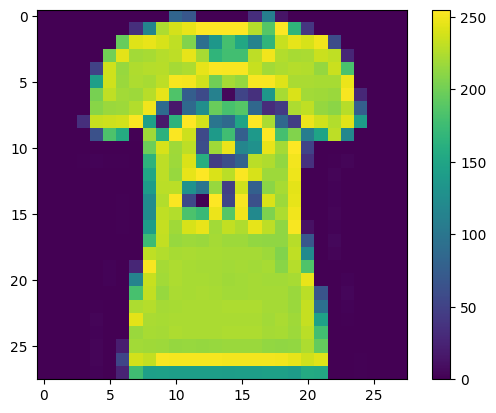

class name : T-shirt/top


In [3]:
# 데이터 확인 용으로 하나의 데이터를 임의 선택 후 이미지와 레이블 확인
from numpy import random
num = random.randint(0, 60000)

plt.figure()
plt.imshow(train_image[num])
plt.colorbar()
plt.grid(False)
plt.show()

print(f'class name : {data_test.classes[train_label[num]]}')

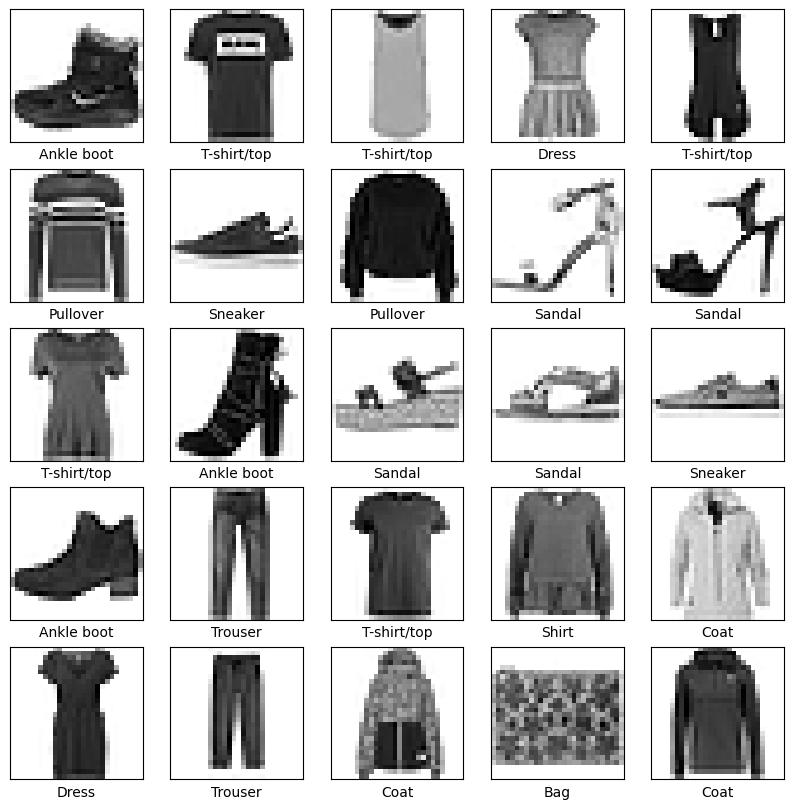

In [4]:
# 데이터 확인 용으로 25개의 데이터와 라벨 확인
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_image[i], cmap=plt.cm.binary) # 이미지 출력
  plt.xlabel(data_test.classes[train_label[i]]) # 레이블 출력
plt.show()

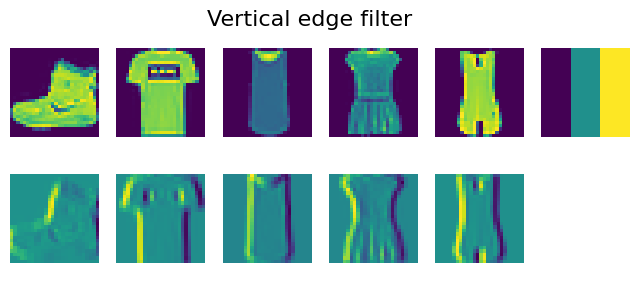

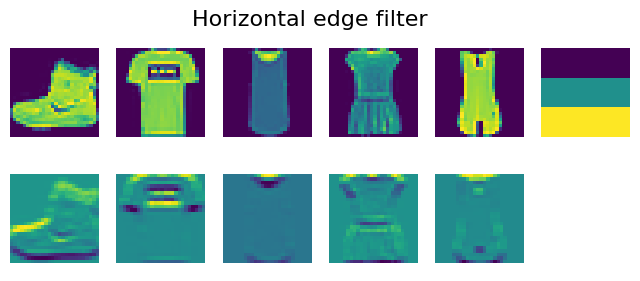

In [5]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')


### 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의

In [6]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명

class OneConv(nn.Module): # nn.Module을 상속받는 OneConv라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self): # 클래스의 생성자로, OneConv 객체가 생성될 때 초기화 과정을 정의
        super(OneConv, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당
        self.flatten = nn.Flatten() # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        self.fc = nn.Linear(5184,10) # 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 로그 소프트맥스 함수를 통해 처리하는데 이 함수는 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용

        return x  # The final processed tensor x, which contains the log probabilities of the classes, is returned from the forward method. This output can be used by a loss function during training to compute the error and update the model weights

# Create an instance of the network
net = OneConv() # OneConv 클래스의 인스턴스를 생성

# Print the summary of the model
summary(net,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


In [7]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

def train(model, train_loader, test_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: # # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            val_loss = test_loss / len(test_loader.dataset)
            val_acc = 100. * test_correct / test_total
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환



Epoch 1/5: Train Loss: 0.0041, Train Acc: 82.41%, Val Loss: 0.0034, Val Acc: 85.15%
Epoch 2/5: Train Loss: 0.0029, Train Acc: 87.06%, Val Loss: 0.0031, Val Acc: 85.91%
Epoch 3/5: Train Loss: 0.0026, Train Acc: 88.22%, Val Loss: 0.0030, Val Acc: 86.48%
Epoch 4/5: Train Loss: 0.0024, Train Acc: 89.00%, Val Loss: 0.0029, Val Acc: 87.16%
Epoch 5/5: Train Loss: 0.0023, Train Acc: 89.70%, Val Loss: 0.0028, Val Acc: 87.47%


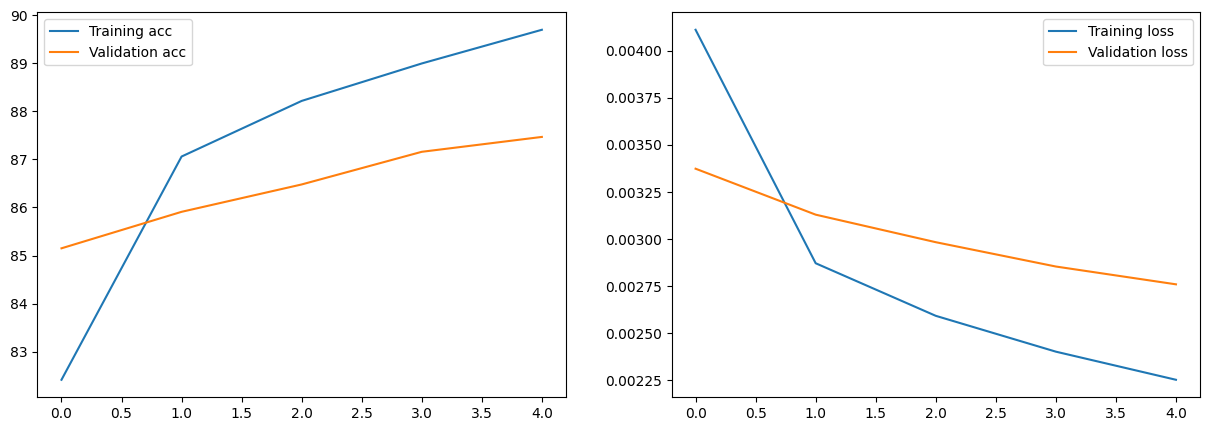

In [8]:
# 신경망 모델 net을 학습시키고 그 결과를 처리하는 과정을 보여줌

# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train(net,train_loader,test_loader,epochs=5)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌

### 혼동행렬을 통해 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지를 식별

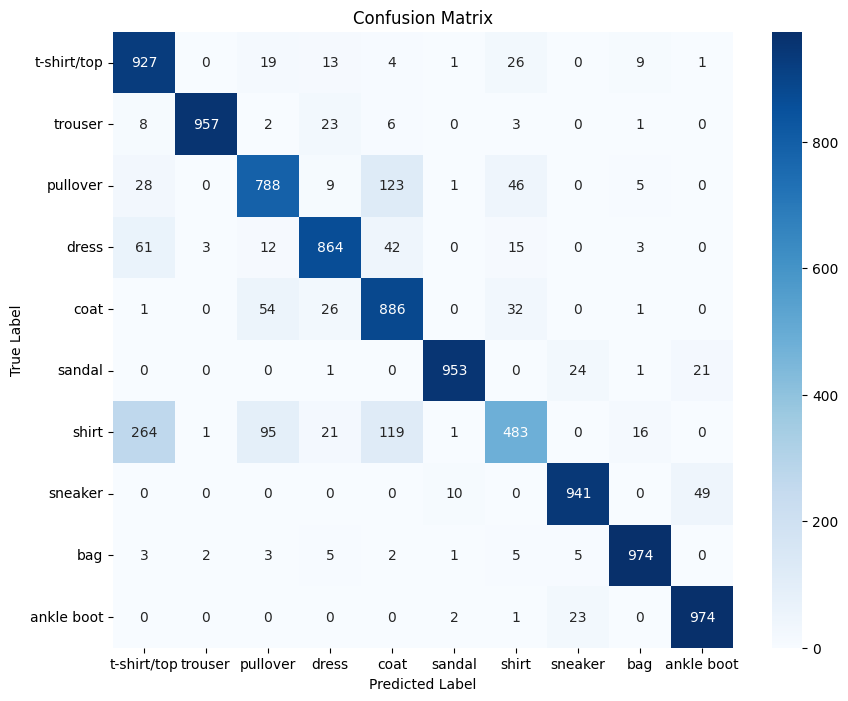

In [9]:
labels_title = { 0: "t-shirt/top", 1: "trouser", 2: "pullover", 3: "dress", 4: "coat", 5: "sandal", 6: "shirt", 7: "sneaker", 8: "bag", 9: "ankle boot"}    # 각 클래스 레이블에 해당하는 아이템을 나타내는 딕셔너리 생성

# 테스트 데이터에 대한 예측 함수 정의
def predict(model, test_loader, device):
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    return predictions, true_labels

# 모델 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
predictions, true_labels = predict(net, test_loader, device)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(true_labels, predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")

# x축과 y축 레이블 설정
tick_labels = [labels_title[i] for i in range(len(labels_title))]  # 클래스 이름 리스트 생성
plt.xticks(ticks=np.arange(len(labels_title))+0.5, labels=tick_labels, rotation=0)  # x축 레이블 설정
plt.yticks(ticks=np.arange(len(labels_title))+0.5, labels=tick_labels, rotation=0)   # y축 레이블 설정

# 그래프 제목 설정
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# 그래프 출력
plt.show()


### 혼동행렬로 확인한 결과 가장 많이 혼동된 클래스는 shirt에 대하여 t-shirt로 확인된다.